In [1]:
import pymolviz as pmv
import numpy as np

## Volumes
Once the data is available there are two major types of displaying them. Via transparent volumes or via isosurfaces. First we will show how to use volumes.


In [2]:
grid = np.array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]])

values = np.sum(grid, axis=1)
grid_data = pmv.GridData(values, grid, name = "grid_data")

In [3]:
v1 = pmv.Volume(grid_data, name = "grid_data_volume")
v1.write("out/basic_volume.py")

A _Volume_ is defined by values which are mapped to (color, alpha) value pairs, with the color for every point inbetween being interpolated. In PyMOLViz, this is done by specifying the _alphas_ and _clims_ keywords for the _Volume_. The _clims_ define the values at which a new color is used by passing the clim to the _Volume's_ _ColorMap_, which can be specified using the _colormap_ keyword in a similar fashion to the _Points_ class.

As an example we will try to show a clearer distinction between points below 1.5 and above 1.5 by adjusting our colormap:

In [4]:
values = [np.min(grid_data.values), 1.5, 1.5, np.max(grid_data.values)]
color_values = [0, 0.35, 0.65, 1]
cmap = pmv.ColorMap(list(zip(values, color_values)), name="distinct_colormap")
v2 = pmv.Volume(grid_data, name = "distinct_volume", colormap = cmap)
pmv.Script([v2, cmap]).write("out/distinct_volume.py")

If we dont want to distinguish so many colors, we can pass different _clims_ to the _Volume_ constructor:


In [5]:
clims = [
    np.min(grid_data.values),
    np.mean(grid_data.values),
    np.max(grid_data.values)
]
v3 = pmv.Volume(grid_data, name = "less_colors_volume", clims = clims)
v3.write("out/less_colors_volume.py")

In [6]:
clims = [
    np.min(grid_data.values),
    np.mean(grid_data.values),
    np.mean(grid_data.values),
    np.max(grid_data.values),
    np.max(grid_data.values)
]
v4 = pmv.Volume(grid_data, name = "less_colors_volume2", clims = clims)
v4.write("out/less_colors_volume2.py")

In [7]:
clims = [
    np.min(grid_data.values),
    np.mean(grid_data.values),
    np.max(grid_data.values)
]
v3 = pmv.Volume(grid_data, name = "less_colors_volume3", clims = clims, alphas = [0.03, 0.005, 0.03])
v3.write("out/less_colors_volume3.py")

By default the clims are chosen as 33 even spaced values between mean plus/minus 5 standard deviations. The alpha values are chosen based on the point densities between the points in that region.

As a more practical example we will show the density around the N-methyl acetamide:


In [8]:
data = pmv.GridData.from_xyz("../data/td.xyz", name = "td")
cmap = pmv.ColorMap([0, 0.5])
v4 = pmv.Volume(data, name = "td_volume", colormap = cmap)
v4.write("out/td_volume.py")

### IsoVolumes
Sometimes it is hard to see what is going on using Volumes (at least in their default setting). In order to simplify generating Volumes showing iso-surfaces PyMOLViz has the class _IsoVolume_. It still makes use of the PyMOLs volume functionality but creates "coloring peaks" at the given values.

In [9]:
cmap = pmv.ColorMap([0, 0.5], colormap = "viridis")
v5 = pmv.IsoVolume(data, name = "td_isovolume", colormap = cmap)
v5.write("out/td_isovolume.py")

In [10]:
from rdkit import Chem
prot = Chem.MolFromPDBFile('../data/4de3.pdb')
positions = prot.GetConformer().GetPositions()
buffer = 5
min_pos = np.min(positions, axis = 0) - buffer
max_pos = np.max(positions, axis = 0) + buffer
data = pmv.GridData.from_mtz('../data/4de3_phases.mtz', min_pos = min_pos, max_pos = max_pos, step_sizes = [1, 1, 1], name = 'mtz_4de3')
cmap = pmv.ColorMap([-1, 1])
v6 = pmv.IsoVolume(data, name = "mtz_4de3_volume", colormap = cmap)
v6.alphas[v6.alphas > 0] = 1
v6.write("out/mtz_4de3_isovolume.py")

In [11]:
v7 = pmv.IsoVolume(data, name = "mtz_4de3_volume", colormap = cmap, carve = 2, selection = "4de3")
v7.alphas[v7.alphas > 0] = 1
v7.write("out/mtz_4de3_isovolume_carved.py")

In [12]:
cmap = pmv.ColorMap([0, .7])
v8 = pmv.IsoVolume(data, clims = np.linspace(0, 1, 32), name = "mtz_4de3_volume", colormap = cmap, carve = 2, selection = "sele")
v8.alphas[v8.alphas > 0] = 1
v8.alphas[v8.alphas == 0] = 0.05
v8.write("out/mtz_4de3_isovolume_carved_sele.py")

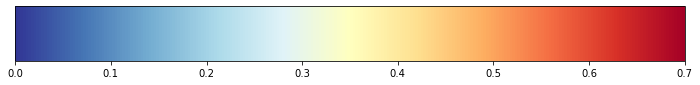

In [13]:
cmap.get_figure(orientation = "horizontal", figsize = (12, 1))

Here we had selected the entire region of the protein when reading in the mtz file and then carved down the display to the selection. A better way to do it would be to restrict the selection of the read in of the mtz file to the region you are interested in.

In [14]:
# bfs from a bromine
bromine = [a for a in prot.GetAtoms() if a.GetAtomicNum() == 35][0]
cur_indices = [bromine.GetIdx()]; found_indices = [bromine.GetIdx()]
while(len(cur_indices) > 0):
    next_indices = [a.GetIdx() for a in prot.GetAtomWithIdx(cur_indices[0]).GetNeighbors() if a.GetIdx() not in found_indices]
    found_indices.extend(next_indices)
    cur_indices.extend(next_indices)
    cur_indices = cur_indices[1:]
# determine box
used_positions = np.array([positions[i] for i in found_indices])
min_pos = np.min(used_positions, axis = 0) - buffer
max_pos = np.max(used_positions, axis = 0) + buffer
data = pmv.GridData.from_mtz('../data/4de3_phases.mtz', min_pos = min_pos, max_pos = max_pos, step_sizes = [1, 1, 1], name = 'mtz_4de3')
cmap = pmv.ColorMap([0, 1])
clims = np.linspace(0, 2, 32)
v9 = pmv.IsoVolume(data, name = "mtz_4de3_volume", colormap = cmap, selection = "sele", carve = 2, clims = clims)
v9.alphas[v9.alphas > 0] = 1
v9.write("out/mtz_4de3_isovolume_small.py")

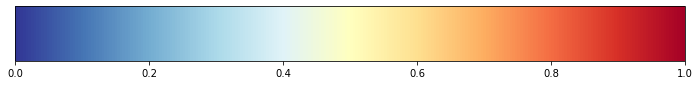

In [15]:
cmap.get_figure(orientation = "horizontal", figsize = (12, 1))